#### Importing Libraries Used

In [48]:
import pandas as pd
import pandas as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from num2words import num2words
import unidecode
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import pickle

##### Reading the Dataset

In [3]:
data=pd.read_csv('train dataset.csv')
data.head(10)

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
5,"Today I reached 1000 subscribers on YT!! , #go...",joy
6,"@Singaholic 121 Good morning, love! Happy firs...",joy
7,#BridgetJonesBaby is the best thing I've seen ...,joy
8,Just got back from seeing @GaryDelaney in Burs...,joy
9,@IndyMN I thought the holidays could not get a...,joy


##### Data Properties

In [4]:
print(data.dtypes)

text     object
label    object
dtype: object


In [5]:
print(data.shape)

(3613, 2)


##### Checking for Null Values in dataset

In [6]:
print(data.isnull().sum())

text     0
label    0
dtype: int64


In [7]:
print(data.isna().sum())

text     0
label    0
dtype: int64


##### Unique value in target

In [8]:
print(data['label'].nunique())

4


In [9]:
print(data['label'].unique())

['joy' 'fear' 'anger' 'sadness']


##### Creating hashmap to store each label and its frequency

In [10]:
dic={'joy':0,'fear':0,'anger':0,'sadness':0}
for i in data['label']:
    dic[i]=dic[i]+1

In [11]:
print(dic)

{'joy': 823, 'fear': 1147, 'anger': 857, 'sadness': 786}


In [12]:
n=len(data)
for i in data['label'].unique():
    print(i, round((dic[i]/n)*100,2))

joy 22.78
fear 31.75
anger 23.72
sadness 21.75


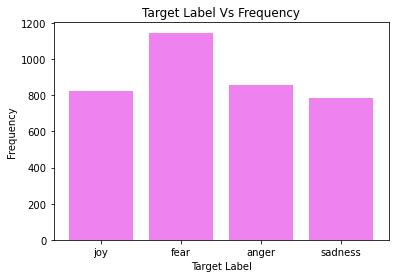

In [13]:
x=list(dic.keys())
y=list(dic.values())
plt.bar(range(len(dic)),y,tick_label=x,color='violet')
plt.title('Target Label Vs Frequency')
plt.xlabel('Target Label')
plt.ylabel('Frequency')
plt.show()

##### This shows that the dataset is balanced dataset

##### Data Pre-Processing and Exploratory Data Analysis

##### Converting text into lowercase

In [14]:
def convert_lowercase(sent):
    sent=sent.lower()
    return sent

In [15]:
data['text']=data['text'].apply(convert_lowercase)

##### Removing punctuations in text column

In [16]:
def remove_punctuation(sen):
    for punctuations in string.punctuation:
        sen=sen.replace(punctuations,'')
    return sen

In [17]:
data['text']=data['text'].apply(remove_punctuation)

##### Convert Number to Words

In [18]:
def num_to_words(text):
    # splitting text into words with space
    after_spliting = text.split()

    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

In [19]:
data['text']=data['text'].apply(num_to_words)

##### Again removing punctuation due to applying number to word function, It may contain '-' between words

In [20]:
data['text']=data['text'].apply(remove_punctuation)

In [21]:
data.head(10)

,text,label
0,just got back from seeing garydelaney in bursl...,joy
1,oh dear an evening of absolute hilarity i dont...,joy
2,been waiting all week for this game ❤️❤️❤️ che...,joy
3,gardinerlove thank you so much gloria youre so...,joy
4,i feel so blessed to work with the family that...,joy
5,today i reached one thousand subscribers on yt...,joy
6,singaholic one hundred and twentyone good morn...,joy
7,bridgetjonesbaby is the best thing ive seen in...,joy
8,just got back from seeing garydelaney in bursl...,joy
9,indymn i thought the holidays could not get an...,joy


##### Convert Accented Characters to ASCII Characters

In [22]:
def to_ascii(x):
    x = unidecode.unidecode(x)
    return x

In [23]:
data['text']=data['text'].apply(to_ascii)

##### Convert sms language into correct words

In [24]:
short_form_list = open('slang.txt', 'r')
chat_words_str = short_form_list.read()

chat_words_map_dict = []
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != " ":
        s=line.split('=')
        chat_words_map_dict.append(s)
        chat_words_list.append(s[0])
        

In [25]:
def short_to_original(text):

    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            for i in chat_words_map_dict:
                if i[0]==w.upper():
                    new_text.append(i[1])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [26]:
data['text']=data['text'].apply(short_to_original)

##### Removing Emoji's in text

In [27]:
def remove_emojis(text):

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji


In [28]:
data['text']=data['text'].apply(remove_emojis)

In [29]:
data.head(10)

,text,label
0,just got back from seeing garydelaney in bursl...,joy
1,oh dear an evening of absolute hilarity i dont...,joy
2,been waiting all week for this game cheer friday,joy
3,gardinerlove thank you so much gloria youre so...,joy
4,i feel so blessed to work with the family that...,joy
5,today i reached one thousand subscribers on yt...,joy
6,singaholic one hundred and twentyone good morn...,joy
7,bridgetjonesbaby is the best thing ive seen in...,joy
8,just got back from seeing garydelaney in bursl...,joy
9,indymn i thought the holidays could not get an...,joy


##### Removing Stopwords from Text

In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\music\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

##### Lemmetizing the text

In [32]:
lemma = WordNetLemmatizer()
def lemmatization(text):

    # word tokenization
    tokens = word_tokenize(text)

    for index in range(len(tokens)):
        # lemma word
        lemma_word = lemma.lemmatize(tokens[index])
        tokens[index] = lemma_word

    return ' '.join(tokens)

In [33]:
# initialize lemmatizer object
data['text']=data['text'].apply(lemmatization)

##### Tokenising to create bar plot with most frequent in each section and their frequency

In [34]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'violet')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

##### Words in JOY Vs Frequency of word

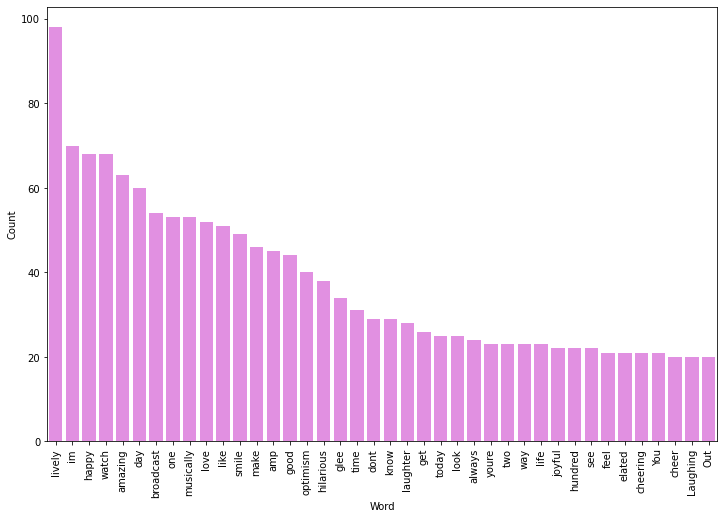

In [35]:
counter(data[data["label"] == "joy"], "text", 40)

##### Words in FEAR Vs Frequency of word

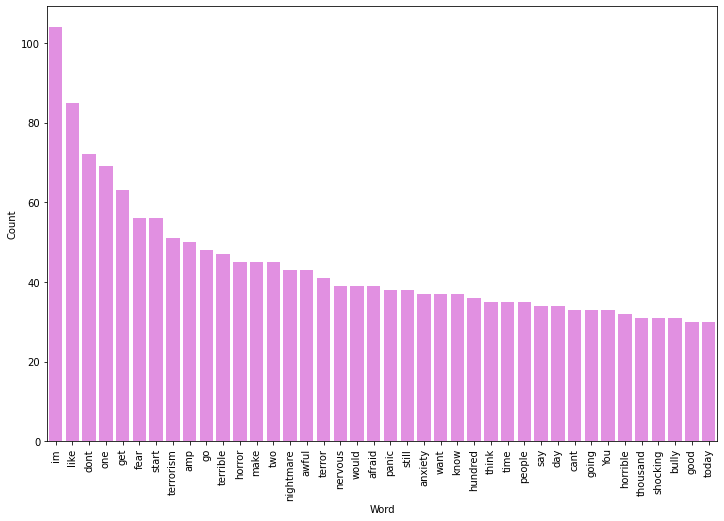

In [36]:
counter(data[data["label"] == "fear"], "text", 40)

##### Words in ANGER Vs Frequency of word

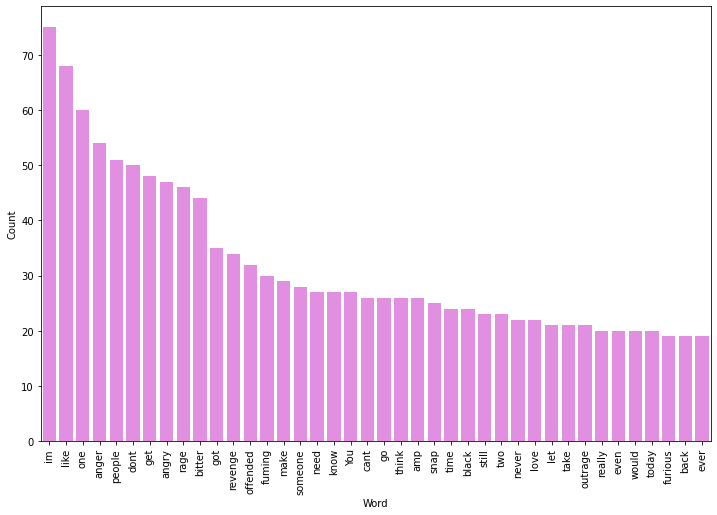

In [37]:
counter(data[data["label"] == "anger"], "text", 40)

##### Words in SADNESS Vs Frequency of word

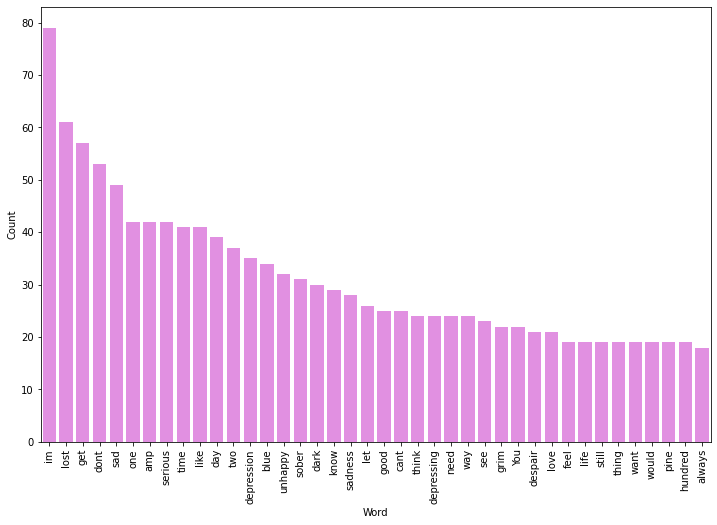

In [38]:
counter(data[data["label"] == "sadness"], "text", 40)

##### Label Encoding

In [39]:
label={'joy':1,'fear':2,'anger':3,'sadness':4}

In [40]:
def labelencode(x):
    return label[x]

In [41]:
data['label']=data['label'].apply(labelencode)

In [42]:
data.head(10)

,text,label
0,got back seeing garydelaney burslem amazing fa...,1
1,oh dear evening absolute hilarity dont think l...,1
2,waiting week game cheer friday,1
3,gardinerlove thank much gloria youre sweet tho...,1
4,feel blessed work family nanny nothing love am...,1
5,today reached one thousand subscriber yt goodd...,1
6,singaholic one hundred twentyone good morning ...,1
7,bridgetjonesbaby best thing ive seen age funny...,1
8,got back seeing garydelaney burslem amazing fa...,1
9,indymn thought holiday could get cheerful met ...,1


##### Train Test Split

In [43]:
x=data['text']
y=data['label']

In [44]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

##### TF-IDF Vectorizer to Convert a text into a Vector

In [45]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [46]:
tfidf_train.shape,tfidf_test.shape

((2529, 7582), (1084, 7582))

##### Creating Pickle file to store Vectorizer Model

In [51]:
Pkl_filename = "tfidf.pkl"  
pickle.dump(tfidf_vectorizer, open(Pkl_filename, 'wb'))

##### Classification Models

##### Logistics Regression

In [52]:
lr=LogisticRegression(random_state=0)
lr.fit(tfidf_train,y_train)
yprediction1=lr.predict(tfidf_test)

In [53]:
print("Accuaracy Percentage ",accuracy_score(yprediction1,y_test))

Accuaracy Percentage  0.8228782287822878


In [54]:
print(classification_report(yprediction1, y_test))

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       230
           2       0.91      0.75      0.82       420
           3       0.81      0.84      0.82       230
           4       0.69      0.83      0.75       204

    accuracy                           0.82      1084
   macro avg       0.81      0.84      0.82      1084
weighted avg       0.83      0.82      0.82      1084



##### Naive Bayes Classifier

In [55]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(tfidf_train, y_train)
yprediction2=model_naive.predict(tfidf_test)

In [56]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction2,y_test),2))

Accuaracy Percentage  0.74


In [57]:
print(classification_report(yprediction2, y_test))

              precision    recall  f1-score   support

           1       0.71      0.91      0.80       195
           2       0.94      0.61      0.74       539
           3       0.71      0.85      0.77       201
           4       0.51      0.85      0.64       149

    accuracy                           0.74      1084
   macro avg       0.72      0.80      0.74      1084
weighted avg       0.80      0.74      0.74      1084



##### Decision Tree Classifier

In [58]:
dt=DecisionTreeClassifier(random_state=0)
dt.fit(tfidf_train,y_train)
yprediction3=dt.predict(tfidf_test)

In [59]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction3,y_test),2))

Accuaracy Percentage  0.8


In [60]:
print(classification_report(yprediction3, y_test))

              precision    recall  f1-score   support

           1       0.87      0.88      0.88       247
           2       0.83      0.75      0.79       385
           3       0.75      0.81      0.78       219
           4       0.74      0.79      0.76       233

    accuracy                           0.80      1084
   macro avg       0.80      0.81      0.80      1084
weighted avg       0.80      0.80      0.80      1084



##### Random Forest Classifier

In [61]:
rf=RandomForestClassifier(n_estimators=50)
rf.fit(tfidf_train,y_train)
yprediction4=rf.predict(tfidf_test)

In [62]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction4,y_test),2))

Accuaracy Percentage  0.83


In [63]:
print(classification_report(yprediction4, y_test))

              precision    recall  f1-score   support

           1       0.88      0.94      0.91       234
           2       0.89      0.77      0.83       403
           3       0.74      0.88      0.80       200
           4       0.77      0.77      0.77       247

    accuracy                           0.83      1084
   macro avg       0.82      0.84      0.83      1084
weighted avg       0.83      0.83      0.83      1084



##### Support Vector Machine

In [64]:
svm=LinearSVC()
svm.fit(tfidf_train,y_train)
yprediction5=svm.predict(tfidf_test)

In [65]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction5,y_test),2))

Accuaracy Percentage  0.85


In [66]:
print(classification_report(yprediction5, y_test))

              precision    recall  f1-score   support

           1       0.92      0.93      0.93       246
           2       0.87      0.84      0.86       361
           3       0.84      0.83      0.83       239
           4       0.77      0.79      0.78       238

    accuracy                           0.85      1084
   macro avg       0.85      0.85      0.85      1084
weighted avg       0.85      0.85      0.85      1084



##### Passive Agressive Classifier

In [67]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
yprediction6=pac.predict(tfidf_test)

In [68]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction6,y_test),2))

Accuaracy Percentage  0.84


In [69]:
print(classification_report(yprediction6, y_test))

              precision    recall  f1-score   support

           1       0.92      0.93      0.93       248
           2       0.85      0.85      0.85       349
           3       0.83      0.81      0.82       244
           4       0.77      0.78      0.77       243

    accuracy                           0.84      1084
   macro avg       0.84      0.84      0.84      1084
weighted avg       0.84      0.84      0.84      1084



##### Ada-Boost Classifier

In [70]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(tfidf_train,y_train)
yprediction7=clf.predict(tfidf_test)

In [71]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction7,y_test),2))

Accuaracy Percentage  0.75


In [72]:
print(classification_report(yprediction7, y_test))

              precision    recall  f1-score   support

           1       0.75      0.92      0.83       204
           2       0.93      0.64      0.76       504
           3       0.65      0.84      0.73       184
           4       0.62      0.80      0.70       192

    accuracy                           0.75      1084
   macro avg       0.74      0.80      0.75      1084
weighted avg       0.79      0.75      0.76      1084



##### Gradient Boosting Classifier

In [73]:
gbc=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
gbc.fit(tfidf_train,y_train)
yprediction8=gbc.predict(tfidf_test)

In [74]:
print("Accuaracy Percentage ",round(accuracy_score(yprediction8,y_test),2))

Accuaracy Percentage  0.82


In [75]:
print(classification_report(yprediction8, y_test))

              precision    recall  f1-score   support

           1       0.84      0.91      0.88       233
           2       0.91      0.74      0.82       431
           3       0.75      0.85      0.80       209
           4       0.73      0.85      0.79       211

    accuracy                           0.82      1084
   macro avg       0.81      0.84      0.82      1084
weighted avg       0.83      0.82      0.82      1084



#### Pickling model

In [76]:
Pkl_Filename = "edm.pkl"  
pickle.dump(svm, open(Pkl_Filename, 'wb'))